# **Impact Assessment**

### Import processing and prepping libraries

In [1]:
#import data processing libraries
import pandas as pd
import numpy as np
import psycopg2
import pymysql
import datetime as dt
from datetime import timedelta
import os
import math as math
from scipy import stats

#import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import joblib
import pyarrow as pa
import pickle
import umap

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Load the Data

In [3]:
repayments = pd.read_csv("repayments_by_different_milestones.csv")

repayments['store_number'] = repayments['store_number'].astype(str)

repayments.head(3)

,loan_surrogate_id,loan_mifos_id,store_number,principal_disbursed,term_frequency,repayment_amount_by_due_date,repayment_amount_by_rllvr_date,repayment_amount_by_dpd30
0,5475396,315040,7032770,19500.000,7,NaN,20711.650,20711.650
1,5475513,60991,7850981,55000.000,7,NaN,NaN,NaN
2,5471575,62008,7258160,10000.000,7,NaN,10410.000,10410.000


In [4]:
repayments = repayments[(repayments['term_frequency'] == 7) | (repayments['term_frequency'] == 21)]

In [5]:
repayments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260922 entries, 0 to 286376
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_surrogate_id               260922 non-null  int64  
 1   loan_mifos_id                   260922 non-null  int64  
 2   store_number                    260922 non-null  object 
 3   principal_disbursed             260922 non-null  float64
 4   term_frequency                  260922 non-null  int64  
 5   repayment_amount_by_due_date    212051 non-null  float64
 6   repayment_amount_by_rllvr_date  234608 non-null  float64
 7   repayment_amount_by_dpd30       244299 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 17.9+ MB


In [6]:
repayments['repayment_amount_by_due_date'] = repayments['repayment_amount_by_due_date'].fillna(0)
repayments['repayment_amount_by_rllvr_date'] = repayments['repayment_amount_by_rllvr_date'].fillna(0)
repayments['repayment_amount_by_dpd30'] = repayments['repayment_amount_by_dpd30'].fillna(0)

In [7]:
repayments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260922 entries, 0 to 286376
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_surrogate_id               260922 non-null  int64  
 1   loan_mifos_id                   260922 non-null  int64  
 2   store_number                    260922 non-null  object 
 3   principal_disbursed             260922 non-null  float64
 4   term_frequency                  260922 non-null  int64  
 5   repayment_amount_by_due_date    260922 non-null  float64
 6   repayment_amount_by_rllvr_date  260922 non-null  float64
 7   repayment_amount_by_dpd30       260922 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 17.9+ MB


In [8]:
repayments['repayment_rate_by_due_date'] = round(repayments['repayment_amount_by_due_date'] / repayments['principal_disbursed'], 4)
repayments['repayment_rate_by_rllvr_date'] = round(repayments['repayment_amount_by_rllvr_date'] / repayments['principal_disbursed'], 4)
repayments['repayment_rate_by_dpd30'] = round(repayments['repayment_amount_by_dpd30'] / repayments['principal_disbursed'], 4)

repayments.head(3)

,loan_surrogate_id,loan_mifos_id,store_number,principal_disbursed,term_frequency,repayment_amount_by_due_date,repayment_amount_by_rllvr_date,repayment_amount_by_dpd30,repayment_rate_by_due_date,repayment_rate_by_rllvr_date,repayment_rate_by_dpd30
0,5475396,315040,7032770,19500.000,7,0.000,20711.650,20711.650,0.000,1.062,1.062
1,5475513,60991,7850981,55000.000,7,0.000,0.000,0.000,0.000,0.000,0.000
2,5471575,62008,7258160,10000.000,7,0.000,10410.000,10410.000,0.000,1.041,1.041


In [9]:
hurdle_rate_by_due_date = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_due_date'].mean()
hurdle_rate_by_due_date = hurdle_rate_by_due_date.rename(columns={'repayment_rate_by_due_date':'hurdle_rate_by_due_date_mean'})

hurdle_rate_by_rllvr_date = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_rllvr_date'].mean()
hurdle_rate_by_rllvr_date = hurdle_rate_by_rllvr_date.rename(columns={'repayment_rate_by_rllvr_date':'hurdle_rate_by_end_rollover_date_mean'})

hurdle_rate_by_dpd30 = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_dpd30'].mean()
hurdle_rate_by_dpd30 = hurdle_rate_by_dpd30.rename(columns={'repayment_rate_by_dpd30':'hurdle_rate_by_dpd30_mean'})

hurdle_rates_df = pd.merge(hurdle_rate_by_due_date, hurdle_rate_by_rllvr_date, on='store_number', how='outer')
hurdle_rates_df = pd.merge(hurdle_rates_df, hurdle_rate_by_dpd30, on='store_number', how='outer')

hurdle_rates_df = hurdle_rates_df.fillna(0)

hurdle_rates_df.head(3)

,store_number,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,105295,1.087,1.087,1.087
1,105570,0.000,0.000,0.000
2,105652,0.842,0.842,0.969


In [10]:
current_refresh = pd.read_parquet("Limits_refresh_summary_20230817_multiple_products.parquet")

del current_refresh['hurdle_rate_by_due_date_mean']
del current_refresh['hurdle_rate_by_end_rollover_date_mean']
del current_refresh['hurdle_rate_by_dpd30_mean']

current_refresh['store_number'] = current_refresh['store_number'].astype(str)

current_refresh.head(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,opt_in_date,model_version,created_at
0,254799950875,7394074,54825.000,2023-07-18,2023-08-16,30,29,0.970,relax_rules,0.000,Yes,1.000,35377425,Approve,0.000,True,True,254799950875,2,300.000,7.000,8500.000,6134.800,2023-08-11,2023-08-18,NaT,2023-08-18,-2.000,2.000,current_active,467.000,8500.000,2023-08-11,2.000,1.000,5.000,1,2,1.031,1,1,NaN,1,pass,13800,6800,7000,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 2,0.250,0.150,0.150,1.000,1.000,1,1.000,0.250,0.150,0.150,13706.250,8223.750,8223.750,13706.250,8223.750,8223.750,13800,6900,0,0,0,0,6800,0,2022-04-26,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27
1,254725499407,7258044,26055.000,2023-07-18,2023-08-16,30,30,1.000,relax_rules,0.000,Yes,1.000,27722601,Approve,0.000,True,True,254725499407,3,300.000,7.000,3700.000,0.000,2023-08-13,2023-08-20,NaT,2023-08-20,-4.000,2.000,current_active,473.000,3700.000,2023-08-13,3.000,1.000,3.000,1,3,1.031,1,1,NaN,1,pass,7900,3200,4700,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 3,0.300,0.175,0.175,1.000,1.000,1,1.000,0.300,0.175,0.150,7816.500,4559.625,3908.250,7816.500,4559.625,3908.250,7900,4000,0,0,0,0,3200,0,2022-02-28,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27


In [11]:
current_refresh = pd.merge(current_refresh, hurdle_rates_df, on='store_number', how='left')

current_refresh.head(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,opt_in_date,model_version,created_at,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,254799950875,7394074,54825.000,2023-07-18,2023-08-16,30,29,0.970,relax_rules,0.000,Yes,1.000,35377425,Approve,0.000,True,True,254799950875,2,300.000,7.000,8500.000,6134.800,2023-08-11,2023-08-18,NaT,2023-08-18,-2.000,2.000,current_active,467.000,8500.000,2023-08-11,2.000,1.000,5.000,1,2,1.031,1,1,NaN,1,pass,13800,6800,7000,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 2,0.250,0.150,0.150,1.000,1.000,1,1.000,0.250,0.150,0.150,13706.250,8223.750,8223.750,13706.250,8223.750,8223.750,13800,6900,0,0,0,0,6800,0,2022-04-26,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27,1.031,1.031,1.031
1,254725499407,7258044,26055.000,2023-07-18,2023-08-16,30,30,1.000,relax_rules,0.000,Yes,1.000,27722601,Approve,0.000,True,True,254725499407,3,300.000,7.000,3700.000,0.000,2023-08-13,2023-08-20,NaT,2023-08-20,-4.000,2.000,current_active,473.000,3700.000,2023-08-13,3.000,1.000,3.000,1,3,1.031,1,1,NaN,1,pass,7900,3200,4700,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 3,0.300,0.175,0.175,1.000,1.000,1,1.000,0.300,0.175,0.150,7816.500,4559.625,3908.250,7816.500,4559.625,3908.250,7900,4000,0,0,0,0,3200,0,2022-02-28,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27,1.031,1.031,1.031


In [12]:
current_refresh['days_since_last_trx'] = current_refresh['days_since_last_trx'].fillna(31)

In [13]:
current_refresh[['final_21_limit', 'final_7_limit', 'final_1_limit']].sum()

final_21_limit     88967200
final_7_limit     117512000
final_1_limit             0
dtype: int64

In [14]:
selected_columns = current_refresh[["store_number", "approx_30_days_trx_val", "expected_trx_days","actual_trx_days","page_active_days", "days_since_last_trx", "weight_consistency", "weight_recency", "hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]]

selected_columns.head(2)

,store_number,approx_30_days_trx_val,expected_trx_days,actual_trx_days,page_active_days,days_since_last_trx,weight_consistency,weight_recency,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,7394074,54825.000,30,29,0.970,0.000,1.000,1,1.031,1.031,1.031
1,7258044,26055.000,30,30,1.000,0.000,1.000,1,1.031,1.031,1.031


In [15]:
selected_columns_corr = selected_columns[["approx_30_days_trx_val", "page_active_days", "days_since_last_trx", "weight_recency", "weight_consistency", "expected_trx_days", "actual_trx_days"]]

<Axes: >

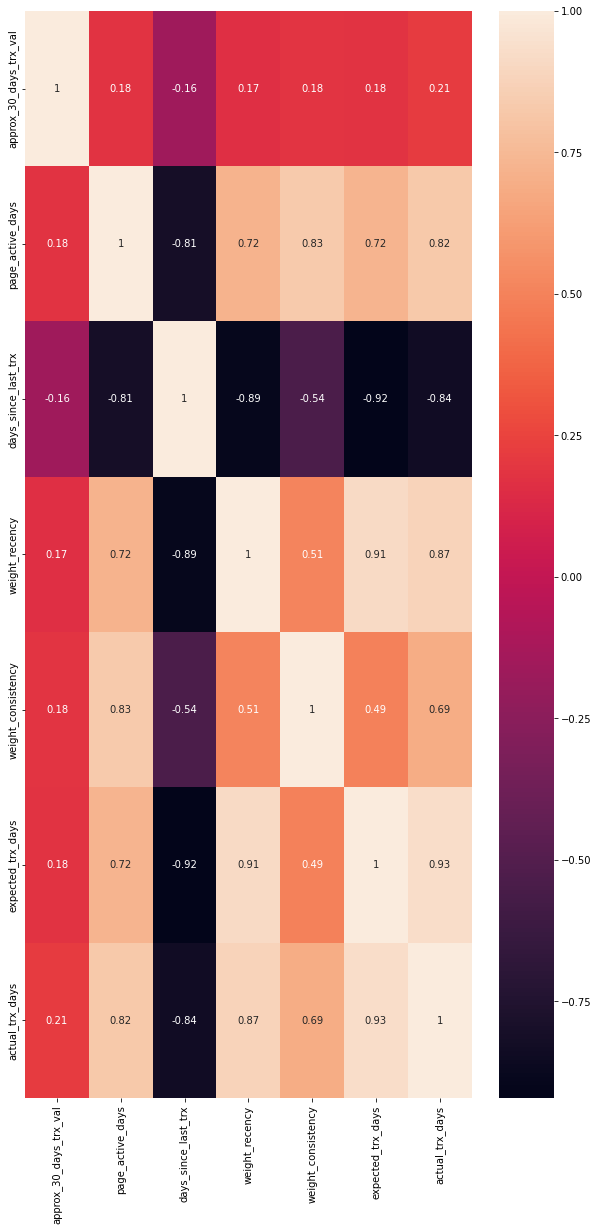

In [16]:
#Correlation analysis
correlations = selected_columns_corr.corr()

f, ax = plt.subplots(figsize = (10, 20))
sns.heatmap(correlations, annot = True)

In [17]:
without_performance_data = selected_columns[selected_columns['hurdle_rate_by_due_date_mean'].isnull()]
print(without_performance_data.shape)
with_performance_data = selected_columns[selected_columns['hurdle_rate_by_due_date_mean'].notnull()]
print(with_performance_data.shape)

(32984, 11)
(32449, 11)


In [18]:
with_performance_data[with_performance_data['hurdle_rate_by_end_rollover_date_mean'] > 1.02].shape

(9515, 11)

In [19]:
summaries = with_performance_data.copy()

In [20]:
# Features for clustering
# features = ["approx_30_days_trx_val", "page_active_days", "days_since_last_trx"]
features = ["approx_30_days_trx_val", "page_active_days", "days_since_last_trx", "weight_recency", "weight_consistency", "actual_trx_days"]

In [21]:
# Split performance data into training and testing subsets
train_with_performance_data, test_with_performance_data = train_test_split(with_performance_data, test_size=0.2, random_state=42)

In [22]:
# Scale the training data
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform scaler on training data
scaled_train_with_performance_data = scaler.fit_transform(train_with_performance_data[features])

In [77]:
with open("scaler_model.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [23]:
# Apply PCA to the features and choose the number of components to retain
pca = PCA(n_components=2)  # You can adjust the number of components

# Apply PCA to the scaled training data
pca_scaled_train_with_performance_data = pca.fit_transform(scaled_train_with_performance_data)

In [78]:
with open("pca_model.pkl", "wb") as f:
    pickle.dump(pca, f)

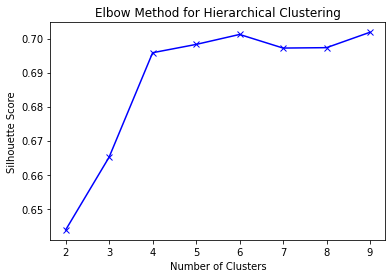

In [24]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
range_values = range(2, 10)  # Start from 2 clusters as 1 cluster doesn't make sense

for n_clusters in range_values:
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_clustering.fit(pca_scaled_train_with_performance_data)
    cluster_labels = hierarchical_clustering.labels_
    
    silhouette_scores.append(silhouette_score(pca_scaled_train_with_performance_data, cluster_labels))

# Plot the silhouette scores
plt.plot(range_values, silhouette_scores, 'bx-')
plt.title('Elbow Method for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [82]:
# Fit hierarchical clustering to PCA-transformed training data
num_clusters = 7  # You can adjust the number of clusters
hierarchical = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean")
train_clusters = hierarchical.fit_predict(pca_scaled_train_with_performance_data)

# Transform PCA-transformed testing data
scaled_test_with_performance_data = scaler.transform(test_with_performance_data[features])
pca_scaled_test_with_performance_data = pca.transform(scaled_test_with_performance_data)

# Predict cluster labels for testing data using the trained hierarchical model
test_clusters = hierarchical.fit_predict(pca_scaled_test_with_performance_data)

# Calculate silhouette score for clustering model on testing data
silhouette_avg = silhouette_score(pca_scaled_test_with_performance_data, test_clusters)
print(f"Silhouette Score on Testing Data: {silhouette_avg:.2f}")

Silhouette Score on Testing Data: 0.71


In [26]:
print("Number of unique train clusters:", len(np.unique(train_clusters)))

print("Number of unique test clusters:", len(np.unique(test_clusters)))

Number of unique train clusters: 7
Number of unique test clusters: 7


In [27]:
cluster_counts = np.bincount(train_clusters)

for cluster_label, count in enumerate(cluster_counts):
    print(f"Cluster {cluster_label}: {count} data points")

Cluster 0: 50 data points
Cluster 1: 9636 data points
Cluster 2: 2581 data points
Cluster 3: 4815 data points
Cluster 4: 458 data points
Cluster 5: 6454 data points
Cluster 6: 1965 data points


In [28]:
cluster_counts = np.bincount(test_clusters)

for cluster_label, count in enumerate(cluster_counts):
    print(f"Cluster {cluster_label}: {count} data points")

Cluster 0: 2404 data points
Cluster 1: 131 data points
Cluster 2: 18 data points
Cluster 3: 988 data points
Cluster 4: 812 data points
Cluster 5: 1678 data points
Cluster 6: 459 data points


In [83]:
num_clusters_found = hierarchical.n_clusters_
print(f"Number of clusters found: {num_clusters_found}")

Number of clusters found: 7


In [85]:
import sklearn

In [87]:
sklearn.__version__

'1.0.2'

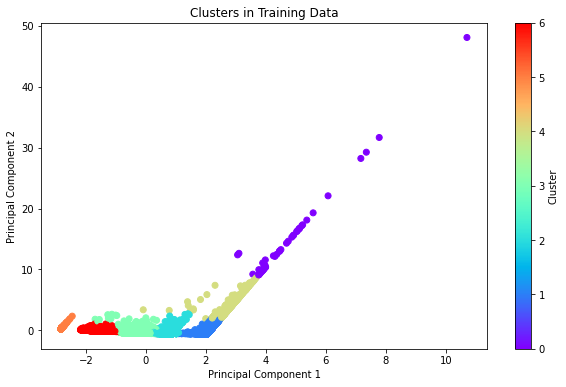

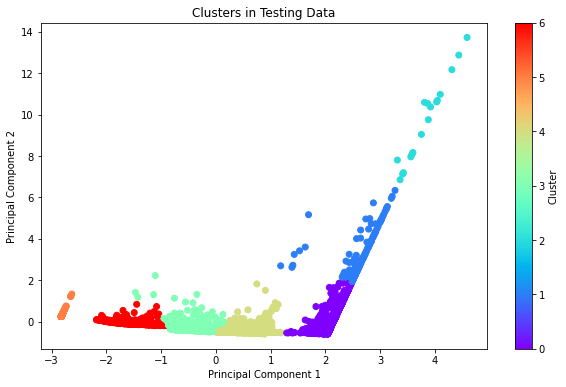

In [30]:
# Visualize training data clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_scaled_train_with_performance_data[:, 0], pca_scaled_train_with_performance_data[:, 1], c=train_clusters, cmap='rainbow')
plt.title("Clusters in Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Visualize testing data clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_scaled_test_with_performance_data[:, 0], pca_scaled_test_with_performance_data[:, 1], c=test_clusters, cmap='rainbow')
plt.title("Clusters in Testing Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [31]:
# Add the "clusters" column to both performance and without_performance data
train_with_performance_data["clusters"] = train_clusters

# Scale the without performance data
scaled_without_performance_data = scaler.transform(without_performance_data[features])

# Apply PCA to scaled without performance data
pca_scaled_without_performance_data = pca.transform(scaled_without_performance_data)

# Predict clusters for PCA-transformed without performance data
train_clusters_without_performance = hierarchical.fit_predict(pca_scaled_without_performance_data)

without_performance_data["clusters"] = train_clusters_without_performance

C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\347589511.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  without_performance_data["clusters"] = train_clusters_without_performance


In [80]:
with open("hierarchical_model_1.pkl", "wb") as f:
    pickle.dump(hierarchical, f)

In [32]:
without_performance_data["clusters"].value_counts()

2    24760
0     5823
5     1159
3     1027
6      171
1       41
4        3
Name: clusters, dtype: int64

In [33]:
train_with_performance_data["clusters"].value_counts()

1    9636
5    6454
3    4815
2    2581
6    1965
4     458
0      50
Name: clusters, dtype: int64

In [34]:
# Calculate cluster means for the columns to predict
cluster_means_model_1 = train_with_performance_data.groupby("clusters")[["hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]].median()

cluster_means_model_1

,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
clusters,,,
0,0.902,1.031,1.033
1,0.821,0.960,1.028
2,0.723,0.884,0.967
3,0.684,0.826,0.915
4,0.922,1.030,1.031
5,0.684,0.782,0.880
6,0.684,0.825,0.919


In [35]:
# Identify the cluster with a large count
largest_main_cluster_index = np.argmax(np.bincount(train_clusters_without_performance))

# Extract data points from the large cluster
largest_main_cluster_data = train_with_performance_data[train_clusters == largest_main_cluster_index]

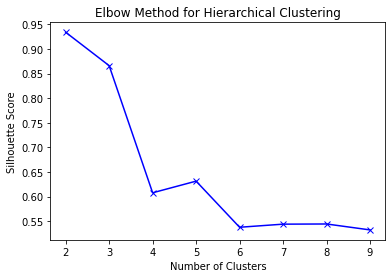

In [36]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
range_values = range(2, 10)  # Start from 2 clusters as 1 cluster doesn't make sense

for n_clusters in range_values:
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_clustering.fit(largest_main_cluster_data)
    cluster_labels = hierarchical_clustering.labels_
    
    silhouette_scores.append(silhouette_score(largest_main_cluster_data, cluster_labels))

# Plot the silhouette scores
plt.plot(range_values, silhouette_scores, 'bx-')
plt.title('Elbow Method for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [37]:
# Perform hierarchical subclustering on the largest main cluster
subcluster_num_clusters = 2
hierarchical_subcluster = AgglomerativeClustering(n_clusters=subcluster_num_clusters, linkage='ward')  # You can adjust the number of subclusters
subcluster_labels = hierarchical_subcluster.fit_predict(largest_main_cluster_data[features])

# Calculate silhouette score for the subclusters
silhouette_avg_subclusters = silhouette_score(largest_main_cluster_data[features], subcluster_labels)
print(f"Silhouette Score for Subclusters in Largest Main Cluster: {silhouette_avg_subclusters:.2f}")

# # Update subcluster labels to renumber them to fit within the existing range
# new_cluster_labels = subcluster_labels.copy()

# # Assign subcluster 0 as Cluster 1 and renumber the rest
# new_cluster_labels[subcluster_labels == 0] = largest_main_cluster_index  # Assign subcluster 0 as Cluster 1
# new_cluster_labels[subcluster_labels == 1] = max(train_clusters) + 1  # Assign subcluster 1 as the next available cluster label
# new_cluster_labels[subcluster_labels == 2] = max(train_clusters) + 2  # Assign subcluster 2 as the next available cluster label

# # Update main cluster labels with subcluster labels for the largest main cluster
# train_clusters[train_clusters == largest_main_cluster_index] = new_cluster_labels

Silhouette Score for Subclusters in Largest Main Cluster: 0.91


In [38]:
cluster_counts = np.bincount(subcluster_labels)

for cluster_label, count in enumerate(cluster_counts):
    print(f"Cluster {cluster_label}: {count} data points")

Cluster 0: 2553 data points
Cluster 1: 28 data points


In [39]:
num_clusters_found = hierarchical_subcluster.n_clusters_
print(f"Number of clusters found: {num_clusters_found}")

Number of clusters found: 2


In [40]:
without_performance_data_max = without_performance_data[without_performance_data["clusters"] == train_clusters_without_performance]

# Scale the without performance data
scaled_without_performance_data_max = scaler.transform(without_performance_data_max[features])

# Apply PCA to scaled without performance data
pca_scaled_without_performance_data_max = pca.transform(scaled_without_performance_data_max)

# Predict clusters for PCA-transformed without performance data
without_performance_data_max["sub_clusters"] = hierarchical_subcluster.fit_predict(pca_scaled_without_performance_data_max)

In [79]:
with open("hierarchical_model_2.pkl", "wb") as f:
    pickle.dump(hierarchical_subcluster, f)

In [41]:
largest_main_cluster_data['sub_clusters'] = subcluster_labels

# Calculate cluster means for the columns to predict
cluster_means_model_2 = largest_main_cluster_data.groupby("sub_clusters")[["hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]].median()

cluster_means_model_2

C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\450517345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  largest_main_cluster_data['sub_clusters'] = subcluster_labels


,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
sub_clusters,,,
0,0.721,0.884,0.963
1,0.947,1.017,1.031


In [42]:
without_performance_data_max['sub_clusters'].value_counts()

0    26134
1     6850
Name: sub_clusters, dtype: int64

In [56]:
cluster_means_model_1 = cluster_means_model_1.rename(columns={'hurdle_rate_by_due_date_mean':'dd', 'hurdle_rate_by_end_rollover_date_mean':'erd', 'hurdle_rate_by_dpd30_mean':'dpd30'})

cluster_means_model_1

,dd,erd,dpd30
clusters,,,
0,0.902,1.031,1.033
1,0.821,0.960,1.028
2,0.723,0.884,0.967
3,0.684,0.826,0.915
4,0.922,1.030,1.031
5,0.684,0.782,0.880
6,0.684,0.825,0.919


In [66]:
# Create an empty DataFrame to store the transformed data
hurdle_rates_pred_model_1 = pd.DataFrame(columns=["cluster", "repayment_milestone", "hurdle_rate"])

# Iterate through each cluster and its associated data
for cluster, repayment_milestone in cluster_means_model_1.iterrows():
    cluster = cluster + 1.0  # Adjust the cluster index to start from 1
    for repayment_milestone, hurdle_rate in repayment_milestone.iteritems():
        hurdle_rates_pred_model_1 = hurdle_rates_pred_model_1.append(
            {"cluster": cluster, "repayment_milestone": repayment_milestone, "hurdle_rate": hurdle_rate}, ignore_index=True
        )
hurdle_rates_pred_model_1
# transformed_df.to_string(index=False)

C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3882774963.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hurdle_rates_pred_model_1 = hurdle_rates_pred_model_1.append(
C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3882774963.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hurdle_rates_pred_model_1 = hurdle_rates_pred_model_1.append(
C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3882774963.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hurdle_rates_pred_model_1 = hurdle_rates_pred_model_1.append(
C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3882774963.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

,cluster,repayment_milestone,hurdle_rate
0,1.000,dd,0.902
1,1.000,erd,1.031
2,1.000,dpd30,1.033
3,2.000,dd,0.821
4,2.000,erd,0.960
5,2.000,dpd30,1.028
6,3.000,dd,0.723
7,3.000,erd,0.884
8,3.000,dpd30,0.967
9,4.000,dd,0.684


In [60]:
cluster_means_model_2 = cluster_means_model_2.rename(columns={'hurdle_rate_by_due_date_mean':'dd', 'hurdle_rate_by_end_rollover_date_mean':'erd', 'hurdle_rate_by_dpd30_mean':'dpd30'})

cluster_means_model_2

,dd,erd,dpd30
sub_clusters,,,
0,0.721,0.884,0.963
1,0.947,1.017,1.031


In [67]:
# Create an empty DataFrame to store the transformed data
hurdle_rates_pred_model_2 = pd.DataFrame(columns=["cluster", "repayment_milestone", "hurdle_rate"])

# Iterate through each cluster and its associated data
for cluster, repayment_milestone in cluster_means_model_2.iterrows():
    if cluster == 0:
        cluster = 3.1
    elif cluster == 1:
        cluster = 3.2
    else:
        cluster = cluster + 1  # Adjust the cluster index to start from 1
    for repayment_milestone, hurdle_rate in repayment_milestone.iteritems():
        hurdle_rates_pred_model_2 = hurdle_rates_pred_model_2.append(
            {"cluster": cluster, "repayment_milestone": repayment_milestone, "hurdle_rate": hurdle_rate}, ignore_index=True
        )
        
hurdle_rates_pred_model_2

C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3971020503.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hurdle_rates_pred_model_2 = hurdle_rates_pred_model_2.append(
C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3971020503.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hurdle_rates_pred_model_2 = hurdle_rates_pred_model_2.append(
C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3971020503.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hurdle_rates_pred_model_2 = hurdle_rates_pred_model_2.append(
C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_40008\3971020503.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

,cluster,repayment_milestone,hurdle_rate
0,3.100,dd,0.721
1,3.100,erd,0.884
2,3.100,dpd30,0.963
3,3.200,dd,0.947
4,3.200,erd,1.017
5,3.200,dpd30,1.031


In [68]:
hurdle_rates_pred = pd.concat([hurdle_rates_pred_model_1, hurdle_rates_pred_model_2])

hurdle_rates_pred

,cluster,repayment_milestone,hurdle_rate
0,1.000,dd,0.902
1,1.000,erd,1.031
2,1.000,dpd30,1.033
3,2.000,dd,0.821
4,2.000,erd,0.960
5,2.000,dpd30,1.028
6,3.000,dd,0.723
7,3.000,erd,0.884
8,3.000,dpd30,0.967
9,4.000,dd,0.684


In [70]:
hurdle_rates_pred = hurdle_rates_pred[~(hurdle_rates_pred['cluster'] == 3)]

hurdle_rates_pred

,cluster,repayment_milestone,hurdle_rate
0,1.000,dd,0.902
1,1.000,erd,1.031
2,1.000,dpd30,1.033
3,2.000,dd,0.821
4,2.000,erd,0.960
5,2.000,dpd30,1.028
9,4.000,dd,0.684
10,4.000,erd,0.826
11,4.000,dpd30,0.915
12,5.000,dd,0.922


In [73]:
hurdle_rates_pred = hurdle_rates_pred.sort_values(by='cluster', ascending=True)

# hurdle_rates_pred['cluster'] = hurdle_rates_pred['cluster'].round(1)

hurdle_rates_pred

,cluster,repayment_milestone,hurdle_rate
0,1.000,dd,0.902
1,1.000,erd,1.031
2,1.000,dpd30,1.033
3,2.000,dd,0.821
4,2.000,erd,0.960
5,2.000,dpd30,1.028
2,3.100,dpd30,0.963
1,3.100,erd,0.884
0,3.100,dd,0.721
5,3.200,dpd30,1.031


In [74]:
hurdle_rates_pred.to_parquet('hurdle_rates_pred.parquet')

In [35]:
# Fill missing values using predicted cluster means
# Predict the cluster labels for rows without performance data
predicted_clusters = without_performance_data["clusters"]
imputed_values = cluster_means.loc[predicted_clusters]
without_performance_data[["hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]] = imputed_values.values

C:\Users\Jackline Ngenia\AppData\Local\Temp\ipykernel_27260\3777348528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  without_performance_data[["hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]] = imputed_values.values


In [36]:
without_performance_data

,store_number,approx_30_days_trx_val,expected_trx_days,actual_trx_days,page_active_days,days_since_last_trx,weight_consistency,weight_recency,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean,clusters
34202,973452,737415.000,30,30,1.000,0.000,1.000,1,0.577,0.743,0.862,2
34248,887042,866625.000,30,30,1.000,0.000,1.000,1,0.898,1.011,1.031,0
34252,7595433,1816945.200,30,30,1.000,0.000,1.000,1,0.898,1.011,1.031,0
34254,905453,1079895.000,30,30,1.000,0.000,1.000,1,0.898,1.011,1.031,0
34288,986604,1987159.500,30,26,0.870,0.000,1.000,1,0.898,1.011,1.031,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65428,998908,24450.000,30,30,1.000,0.000,1.000,1,0.908,1.031,1.033,4
65429,998921,209250.000,30,21,0.700,0.000,0.000,1,0.577,0.743,0.862,2
65430,999501,3075.000,30,26,0.870,0.000,1.000,1,0.908,1.031,1.033,4
65431,999763,204000.000,30,26,0.870,0.000,1.000,1,0.577,0.743,0.862,2


In [37]:
without_performance_data['clusters'].value_counts()

4    22666
2     6714
0      659
1       41
3        3
Name: clusters, dtype: int64

In [38]:
train_with_performance_data['clusters'].value_counts()

5    8453
2    7300
3    7279
6    2341
1    1701
0    1156
4      50
Name: clusters, dtype: int64

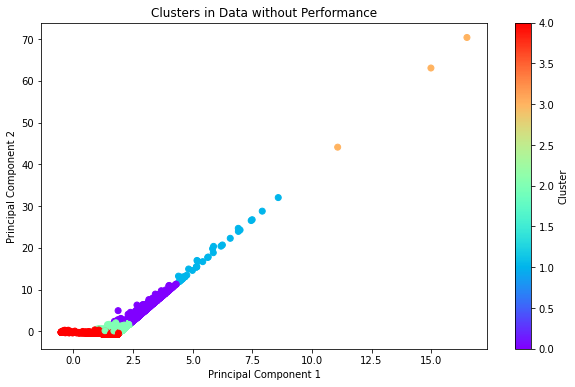

In [39]:
# Visualize clusters in without_performance_data
plt.figure(figsize=(10, 6))
plt.scatter(pca_scaled_without_performance_data[:, 0], pca_scaled_without_performance_data[:, 1], c=without_performance_data["clusters"], cmap='rainbow')
plt.title("Clusters in Data without Performance")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


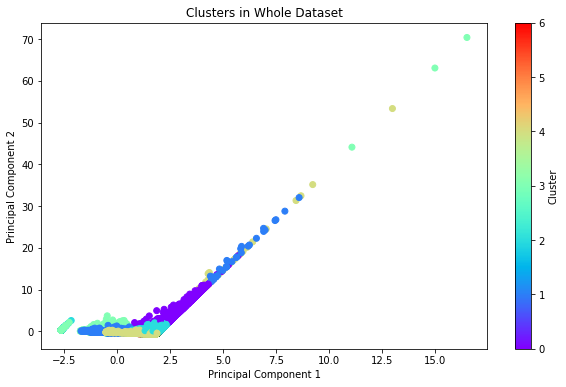

In [40]:
# Combine PCA-transformed data from both subsets
all_pca_data = np.vstack((pca_scaled_train_with_performance_data, pca_scaled_test_with_performance_data, pca_scaled_without_performance_data))

# Combine cluster labels from both subsets
all_clusters = np.concatenate((train_clusters, test_clusters, without_performance_data["clusters"]))

# Visualize clusters in the whole dataset
plt.figure(figsize=(10, 6))
plt.scatter(all_pca_data[:, 0], all_pca_data[:, 1], c=all_clusters, cmap='rainbow')
plt.title("Clusters in Whole Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [41]:
# Concatenate known and imputed data
imputed_df = pd.concat([train_with_performance_data, without_performance_data])

imputed_df.shape

(58363, 12)

In [42]:
imputed_df['clusters'].value_counts()

4    22716
2    14014
5     8453
3     7282
6     2341
0     1815
1     1742
Name: clusters, dtype: int64

In [39]:
imputed_df.head(3)

,store_number,approx_30_days_trx_val,expected_trx_days,actual_trx_days,page_active_days,days_since_last_trx,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean,clusters
1450,7376039,44431.500,30,30,1.000,0.000,0.776,0.776,0.776,4
19191,7545414,0.000,0,0,0.000,31.000,0.684,0.684,0.687,3
2718,7002627,18450.000,30,26,0.870,0.000,0.517,0.517,1.050,4


In [40]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58363 entries, 1450 to 65432
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   store_number                           58363 non-null  object 
 1   approx_30_days_trx_val                 58363 non-null  float64
 2   expected_trx_days                      58363 non-null  int64  
 3   actual_trx_days                        58363 non-null  int64  
 4   page_active_days                       58363 non-null  float64
 5   days_since_last_trx                    58363 non-null  float64
 6   hurdle_rate_by_due_date_mean           58363 non-null  float64
 7   hurdle_rate_by_end_rollover_date_mean  58363 non-null  float64
 8   hurdle_rate_by_dpd30_mean              58363 non-null  float64
 9   clusters                               58363 non-null  int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 4.9+ MB


In [22]:
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [23]:
with open("scaler_model.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
# Create a sample dataframe
data = {'cluster': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5], 'repayment_milestone': ['dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30'], 'hurdle_rate': [round(c1_ratio_by_dd, 3), round(c1_ratio_by_erd, 3), round(c1_ratio_by_dpd30, 3), round(c2_ratio_by_dd, 3), round(c2_ratio_by_erd, 3), round(c2_ratio_by_dpd30, 3), round(c3_ratio_by_dd, 3), round(c3_ratio_by_erd, 3), round(c3_ratio_by_dpd30, 3), round(c4_ratio_by_dd, 3), round(c4_ratio_by_erd, 3), round(c4_ratio_by_dpd30, 3), round(c5_ratio_by_dd, 3), round(c5_ratio_by_erd, 3), round(c5_ratio_by_dpd30, 3)]}
hurdle_rates_pred = pd.DataFrame(data)


In [ ]:
hurdle_rates_pred

In [ ]:
hurdle_rates_pred.to_parquet('hurdle_rates_pred.parquet')

In [ ]:
df = pd.read_parquet('hurdle_rates_pred.parquet')

df